In [1]:
drop_stop = True

# Importing packages

In [61]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
import collections as c
import os
import re
import numpy as np
import scipy.spatial.distance as sp
import math
import matplotlib.pyplot as plt

ps = PorterStemmer() 
sno = SnowballStemmer("english")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\janep\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\janep\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Get list of file names

In [4]:
filenames = []
for fn in os.listdir("enron1\\ham"):
    if fn.endswith(".txt"):
        filenames.append(os.path.join("enron1\\ham", fn.replace("\\", "/")))
        
ham_num = len(filenames)

for fn in os.listdir("enron1\\spam"):
    if fn.endswith(".txt"):
        filenames.append(os.path.join("enron1\\spam", fn.replace("\\", "/")))
    
spam_num = len(filenames) - ham_num

In [5]:
len(filenames)


5172

# Stem email text

In [6]:
#flag to set initial df
first = True
stems_list = []
#iterate through each file
for fn in filenames:  
    #read file
    with open(fn, 'r', encoding="ISO-8859-1") as file:
        
        #remove numbers
        data = re.sub('[0-9]', '', file.read().replace('\n', ' '))
        
        #data = file.read().replace('\n', ' ')
        
        #tokenize + word-stem
        nltk_tokens = word_tokenize(data)
        stems = ""
        for w in nltk_tokens:
            stems += ps.stem(w) + " "
        
        stems_list.append(stems)


# Vectorize counts and get dictionary

In [7]:
#count vectorize
vect = CountVectorizer(input="content")
temp = vect.fit_transform(stems_list)
word_bag = vect.get_feature_names()



In [82]:
df = pd.DataFrame(temp.toarray(), columns=word_bag)
df.drop([col for col, val in df.sum().iteritems() if val <= 50], axis=1, inplace=True)

In [83]:
#dropping stop words

if drop_stop:
    nonstop_attr = df.columns.copy()
    for word in stopwords.words('english'):
        if word in df.columns:
            nonstop_attr = nonstop_attr.drop(word)
else:
    nonstop_attr = df.columns

In [11]:
len(df.columns)-len(nonstop_attr)

119

# Divide data into ham, spam, test, and train

In [84]:
df_nonstop = df[nonstop_attr].copy()[nonstop_attr]

ham_data = df_nonstop[:ham_num]
spam_data = df_nonstop[ham_num:]
ham_data["SPAM_LABEL"] = 0
spam_data["SPAM_LABEL"] = 1

# ptrain_test_split(ham_data, spam_data)
msk = np.random.rand(len(ham_data)) < 0.7
ham_train = ham_data[msk]
ham_test = ham_data[~msk]

msk = np.random.rand(len(spam_data)) < 0.7
spam_train = spam_data[msk]
spam_test = spam_data[~msk]

train_data = pd.concat([ham_train, spam_train])
test_data = pd.concat([ham_test, spam_test])

C:\Users\janep\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\janep\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# K Nearest Neighbors

Setting up parameters

In [119]:
#setting parameters
p = 2
attr = train_data.columns.drop("SPAM_LABEL")

train_data_knn = train_data[attr].copy()
test_data_knn = test_data[attr].copy()


ASDF
HELLLO


In [120]:
#calculate different norms
norms = sp.cdist(test_data_knn, train_data_knn)
norms_1 = sp.cdist(test_data_knn, train_data_knn, "cityblock")
norms_inf = sp.cdist(test_data_knn, train_data_knn, "chebyshev")

KNN functions for different norms

In [122]:
def KNN(k, data):
    y = []
    neighbors = np.apply_along_axis(np.argpartition, 1, norms, k)[:,:k]
    for i in range(test_data.shape[0]):
        y.append(train_data.iloc[list(neighbors[i]), :]["SPAM_LABEL"].mode()[0])
    return np.equal(np.array(y), test_data["SPAM_LABEL"].values).sum()/test_data.shape[0]

def KNN_1(k, data):
    y = []
    neighbors = np.apply_along_axis(np.argpartition, 1, norms_1, k)[:,:k]
    for i in range(test_data.shape[0]):
        y.append(train_data.iloc[list(neighbors[i]), :]["SPAM_LABEL"].mode()[0])
    return np.equal(np.array(y), test_data["SPAM_LABEL"].values).sum()/test_data.shape[0]

def KNN_inf(k, data):
    y = []
    neighbors = np.apply_along_axis(np.argpartition, 1, norms_inf, k)[:,:k]
    for i in range(test_data.shape[0]):
        y.append(train_data.iloc[list(neighbors[i]), :]["SPAM_LABEL"].mode()[0])
    return np.equal(np.array(y), test_data["SPAM_LABEL"].values).sum()/test_data.shape[0]

In [129]:
#get knn performance
list_k = [1, 2, 3, 5, 10, 20, 30, 40, 50, 75, 100, 200]
y_axis = []
y_axis_1 = []
y_axis_inf = []
for k in list_k:
    print("Starting k = " + str(k))
    y_axis.append(KNN(k, test_data))
    y_axis_1.append(KNN_1(k, test_data))
    y_axis_inf.append(KNN_inf(k, test_data))

Starting k = 1
Starting k = 2
Starting k = 3
Starting k = 5
Starting k = 10
Starting k = 20
Starting k = 30
Starting k = 40
Starting k = 50
Starting k = 75
Starting k = 100
Starting k = 200


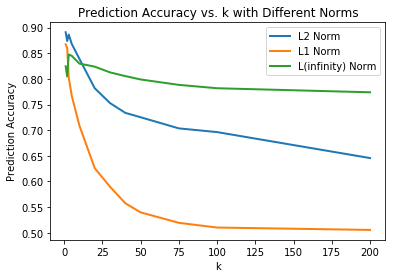

In [130]:
#plot knn
plt.plot(list_k, y_axis, linewidth=2.0, label="L2 Norm")
plt.plot(list_k, y_axis_1, linewidth=2.0, label="L1 Norm")
plt.plot(list_k, y_axis_inf, linewidth=2.0, label="L(infinity) Norm")
plt.legend()
plt.title("Prediction Accuracy vs. k with Different Norms")
plt.ylabel("Prediction Accuracy")
plt.xlabel("k")

plt.show()

# Naive Bayes

We use add-one Laplace smoothing and log the probabilities to avoid zero-frequency problem.

In [105]:
def bayes_prob(row, freq, attr, total):
    p = 0
    for i in range(len(attr)):
        #using add-one laplacian smoothing
        p += math.log((freq[i][row[i+1]]+1)/total)
        
    return p


In [158]:
#get training data
def bayes():
    attr=train_data.columns
    train_data_b0 = train_data[train_data["SPAM_LABEL"]==0]
    train_data_b1 = train_data[train_data["SPAM_LABEL"]==1]

    #build frequency table
    freq_0 = [c.Counter(train_data_b0[col]) for col in attr]
    freq_1 = [c.Counter(train_data_b1[col]) for col in attr]

    #get counts
    counts = train_data["SPAM_LABEL"].value_counts()
    total = counts.sum()

    #get test data
    test_data_bayes = test_data.copy()
    test_data_bayes["SPAM_LABEL_y"] = -1

    #classiying
    for row in test_data.itertuples():
        p_0 = bayes_prob(row, freq_0, attr, counts[0]) + math.log(counts[0]/total)
        p_1 = bayes_prob(row, freq_1, attr, counts[1]) + math.log(counts[1]/total)

    #     print(row[0])
    #     print(p_0)
    #     print(p_1)

        #give label
        if p_0 > p_1:
            test_data_bayes["SPAM_LABEL_y"].loc[row[0]] = 0
        else:
            test_data_bayes["SPAM_LABEL_y"].loc[row[0]] = 1

    return len(test_data_bayes[test_data_bayes["SPAM_LABEL_y"] == test_data_bayes["SPAM_LABEL"]].index)/len(test_data_bayes.index)

In [177]:
bayes()

0.9572649572649573

# Decision tree

Lots of features = lots of time. We trim space by looking at topmost features with highest variance, then consider limited number of thresholds within each feature rather than every possible threshold. 

In [89]:
#copy data
train_data_temp = train_data.copy()
test_data_d = test_data.copy()

#split train and validation sets
msk = np.random.rand(len(train_data_temp)) < 0.9
train_data_d = train_data_temp[msk]
val = train_data_temp[~msk]



In [92]:
#get tree attributes
feat_num = round(len(train_data_d.columns)*.05)
tree_attr = list(train_data_d.var().sort_values(ascending=False)[:feat_num].index)

In [209]:
'''
Tree Class
'''
class Tree:
    def __init__(self):
        self.left = None
        self.right = None
        self.feature = None
        self.threshold = None
        self.label = -1

'''
Calculates Gini impurity
'''        
def gini(p):
    return 1-(p**2+(1-p)**2)


'''
Uses ID3 algorithm to build tree
'''
def ID3(data, y, attr, n):
    t = Tree()
    l = data.shape[0]
    
    #if all data is ham
    if data[y].sum() == 0:
        t.label = 0
        return t
    
    
    #if all data is spam
    elif data[y].sum() == l:
        t.label = 1
        return t
    
    #if we're out of attributes to train on
    elif len(attr) == 0 or n == 0:
        t.label = int(round(data[y].sum()/l))
        return t

    else:
        #get best feature and threshold
        best_f = None
        best_t = None
        best_g = -1
        
        #calculate gini ipurity of whole cell
        p = data[y].sum()/l
        g_total = gini(p)
        
        for a in attr:
            #get data and thresholds to try
            temp = np.array(list(zip(data[a], data[y])))
            thr_list = np.unique(data[a].values)
            
            for thr in thr_list:
                #split cells
                left = temp[temp[:,0] <= thr]
                right = temp[temp[:,0] > thr]
                
                #calculate gini impurity of each
                p_l = np.sum(left[:,1])/l
                p_r = np.sum(right[:,1])/l
                g =  g_total-(left.shape[0]/l*gini(p_l)+right.shape[0]/l*gini(p_r))
                
                #if it's the best feature:
                if g > best_g:
                    best_f = a
                    best_t = thr
                    best_g = g
        
        #set tree node parameters
        t.feature = best_f
        t.threshold = best_t
        
        #split data into cells
        left_data = data[data[best_f] <= best_t]
        right_data = data[data[best_f] > best_t]
        
        #if one cell is empty
        if left_data.shape[0] == 0 or right_data.shape[0] == 0:
            t.label = int(round(data[y].sum()/l))
            return t
        
        #build subtree
        else:
            new_attr = attr.copy()
            new_attr.remove(best_f)
            t.left = ID3(left_data, y, new_attr, n-1)
            t.right = ID3(right_data, y, new_attr, n-1)
        
    return t
        
'''
Uses tree to classify data
'''
def tree_classify(t, test_data):
    y = []
    root = t
    for i in range(test_data.shape[0]):
        t = root
        x = test_data.iloc[i]
        while t.label == -1:
            if x[t.feature] <= t.threshold:
                t = t.left
            else:
                t = t.right
        y.append(t.label)
    return y

'''
Print tree (preorder)
'''

def show(t):
    if t.label == -1:
        print(t.feature, ": ", t.threshold)
        show(t.left)
        show(t.right)
    else:
        print("Label: " + t.label)

We use validation set to see which depth is best.

In [111]:
acc_val = []
for lvl in [5*i for i in range(1, 50)]:
    print("Starting: " + str(lvl))
    t = ID3(train_data_d, "SPAM_LABEL", tree_attr, lvl)
    z = tree_classify(t, val)
    acc_val.append(np.equal(np.array(z), val["SPAM_LABEL"].values).sum()/val.shape[0])

Starting: 5
Best feature: thi
Best feature: hpl
Best feature: pleas
Best feature: http
Best feature: ga
Best feature: enron
Best feature: com
Best feature: ani
Best feature: enron
Best feature: pleas
Best feature: http
Best feature: ha
Best feature: deal
Best feature: inform
Best feature: enron
Best feature: com
Best feature: com
Best feature: subject
Best feature: ani
Best feature: cc
Best feature: enron
Best feature: daren
Starting: 10
Best feature: thi
Best feature: hpl
Best feature: pleas
Best feature: http
Best feature: ga
Best feature: subject
Best feature: deal
Best feature: daren
Best feature: meter
Best feature: enron
Best feature: price
Best feature: pill
Best feature: need
Best feature: product
Best feature: pm
Best feature: meter
Best feature: cc
Best feature: com
Best feature: chang
Best feature: corp
Best feature: deal
Best feature: pm
Best feature: email
Best feature: inform
Best feature: line
Best feature: meter
Best feature: houston
Best feature: enron
Best feature: ne

Best feature: call
Best feature: meter
Best feature: deal
Best feature: day
Best feature: inform
Best feature: need
Best feature: manag
Best feature: price
Best feature: chang
Best feature: pm
Best feature: enron
Best feature: deal
Best feature: ha
Best feature: contract
Best feature: day
Best feature: compani
Best feature: need
Best feature: ect
Best feature: ena
Best feature: cc
Best feature: servic
Best feature: ga
Best feature: http
Best feature: compani
Best feature: enron
Best feature: daren
Best feature: houston
Best feature: pm
Best feature: deal
Best feature: price
Best feature: ticket
Best feature: ect
Starting: 20
Best feature: thi
Best feature: hpl
Best feature: pleas
Best feature: http
Best feature: ga
Best feature: subject
Best feature: deal
Best feature: daren
Best feature: meter
Best feature: enron
Best feature: mmbtu
Best feature: volum
Best feature: pm
Best feature: contract
Best feature: ticket
Best feature: juli
Best feature: tax
Best feature: day
Best feature: wa
B

Best feature: ani
Best feature: deal
Best feature: forward
Best feature: day
Best feature: chang
Best feature: call
Best feature: daren
Best feature: email
Best feature: inform
Best feature: order
Best feature: servic
Best feature: new
Best feature: mmbtu
Best feature: manag
Best feature: style
Best feature: tr
Best feature: enron
Best feature: meter
Best feature: pm
Best feature: juli
Best feature: compani
Best feature: enron
Best feature: ena
Best feature: enron
Best feature: enron
Best feature: ect
Best feature: need
Best feature: order
Best feature: mmbtu
Best feature: enron
Best feature: meter
Best feature: product
Best feature: ticket
Best feature: need
Best feature: sale
Best feature: http
Best feature: subject
Best feature: ga
Best feature: ect
Best feature: email
Best feature: servic
Best feature: enron
Best feature: price
Best feature: http
Best feature: enron
Best feature: houston
Best feature: pm
Best feature: famili
Best feature: ect
Best feature: pleas
Best feature: http


Best feature: chang
Best feature: volum
Best feature: ect
Best feature: ect
Best feature: chang
Best feature: wa
Best feature: daren
Best feature: need
Best feature: meter
Best feature: compani
Best feature: may
Best feature: chang
Best feature: hpl
Best feature: price
Best feature: wa
Best feature: juli
Best feature: ect
Best feature: ga
Best feature: price
Best feature: juli
Best feature: inform
Best feature: deal
Best feature: subject
Best feature: day
Best feature: need
Best feature: chang
Best feature: mmbtu
Best feature: enron
Best feature: meter
Best feature: ect
Best feature: call
Best feature: ani
Best feature: ga
Best feature: email
Best feature: email
Best feature: compani
Best feature: line
Best feature: price
Best feature: meter
Best feature: need
Best feature: volum
Best feature: day
Best feature: mmbtu
Best feature: wa
Best feature: enron
Best feature: meter
Best feature: hpl
Best feature: subject
Best feature: ect
Best feature: enron
Best feature: com
Best feature: chan

Best feature: ena
Best feature: cc
Best feature: servic
Best feature: ga
Best feature: http
Best feature: compani
Best feature: enron
Best feature: daren
Best feature: houston
Best feature: pm
Best feature: deal
Best feature: price
Best feature: ticket
Best feature: ect
Starting: 40
Best feature: thi
Best feature: hpl
Best feature: pleas
Best feature: http
Best feature: ga
Best feature: subject
Best feature: deal
Best feature: daren
Best feature: meter
Best feature: enron
Best feature: mmbtu
Best feature: volum
Best feature: pm
Best feature: contract
Best feature: ticket
Best feature: juli
Best feature: tax
Best feature: day
Best feature: wa
Best feature: sale
Best feature: inform
Best feature: servic
Best feature: robert
Best feature: ect
Best feature: need
Best feature: ani
Best feature: ect
Best feature: email
Best feature: product
Best feature: price
Best feature: pill
Best feature: need
Best feature: meter
Best feature: daren
Best feature: juli
Best feature: path
Best feature: tic

Best feature: ani
Best feature: deal
Best feature: forward
Best feature: day
Best feature: chang
Best feature: call
Best feature: daren
Best feature: email
Best feature: inform
Best feature: order
Best feature: servic
Best feature: new
Best feature: mmbtu
Best feature: manag
Best feature: style
Best feature: tr
Best feature: enron
Best feature: meter
Best feature: pm
Best feature: juli
Best feature: compani
Best feature: contract
Best feature: ect
Best feature: enron
Best feature: ena
Best feature: enron
Best feature: enron
Best feature: ect
Best feature: need
Best feature: order
Best feature: mmbtu
Best feature: enron
Best feature: meter
Best feature: product
Best feature: ticket
Best feature: need
Best feature: sale
Best feature: http
Best feature: subject
Best feature: ga
Best feature: ect
Best feature: email
Best feature: servic
Best feature: enron
Best feature: price
Best feature: http
Best feature: enron
Best feature: houston
Best feature: pm
Best feature: famili
Best feature: ec

Best feature: hpl
Best feature: chang
Best feature: new
Best feature: font
Best feature: ga
Best feature: ani
Best feature: ect
Best feature: enron
Best feature: chang
Best feature: volum
Best feature: ect
Best feature: ect
Best feature: chang
Best feature: wa
Best feature: daren
Best feature: need
Best feature: meter
Best feature: compani
Best feature: may
Best feature: chang
Best feature: hpl
Best feature: price
Best feature: wa
Best feature: juli
Best feature: ect
Best feature: ga
Best feature: price
Best feature: juli
Best feature: inform
Best feature: deal
Best feature: subject
Best feature: day
Best feature: need
Best feature: chang
Best feature: mmbtu
Best feature: enron
Best feature: meter
Best feature: ect
Best feature: call
Best feature: ani
Best feature: ga
Best feature: email
Best feature: email
Best feature: compani
Best feature: line
Best feature: price
Best feature: meter
Best feature: need
Best feature: volum
Best feature: day
Best feature: mmbtu
Best feature: wa
Best f

Best feature: servic
Best feature: ga
Best feature: http
Best feature: compani
Best feature: enron
Best feature: daren
Best feature: houston
Best feature: pm
Best feature: deal
Best feature: price
Best feature: ticket
Best feature: ect
Starting: 60
Best feature: thi
Best feature: hpl
Best feature: pleas
Best feature: http
Best feature: ga
Best feature: subject
Best feature: deal
Best feature: daren
Best feature: meter
Best feature: enron
Best feature: mmbtu
Best feature: volum
Best feature: pm
Best feature: contract
Best feature: ticket
Best feature: juli
Best feature: tax
Best feature: day
Best feature: wa
Best feature: sale
Best feature: inform
Best feature: servic
Best feature: robert
Best feature: ect
Best feature: need
Best feature: ani
Best feature: ect
Best feature: email
Best feature: product
Best feature: price
Best feature: pill
Best feature: need
Best feature: meter
Best feature: daren
Best feature: juli
Best feature: path
Best feature: ticket
Best feature: call
Best feature

Best feature: com
Best feature: ani
Best feature: deal
Best feature: forward
Best feature: day
Best feature: chang
Best feature: call
Best feature: daren
Best feature: email
Best feature: inform
Best feature: order
Best feature: servic
Best feature: new
Best feature: mmbtu
Best feature: manag
Best feature: style
Best feature: tr
Best feature: enron
Best feature: meter
Best feature: pm
Best feature: juli
Best feature: compani
Best feature: contract
Best feature: ect
Best feature: enron
Best feature: ena
Best feature: enron
Best feature: enron
Best feature: ect
Best feature: need
Best feature: order
Best feature: mmbtu
Best feature: enron
Best feature: meter
Best feature: product
Best feature: ticket
Best feature: need
Best feature: sale
Best feature: http
Best feature: subject
Best feature: ga
Best feature: ect
Best feature: email
Best feature: servic
Best feature: enron
Best feature: price
Best feature: http
Best feature: enron
Best feature: houston
Best feature: pm
Best feature: famil

Best feature: meter
Best feature: hpl
Best feature: chang
Best feature: new
Best feature: font
Best feature: ga
Best feature: ani
Best feature: ect
Best feature: enron
Best feature: chang
Best feature: volum
Best feature: ect
Best feature: ect
Best feature: chang
Best feature: wa
Best feature: daren
Best feature: need
Best feature: meter
Best feature: compani
Best feature: may
Best feature: chang
Best feature: hpl
Best feature: price
Best feature: wa
Best feature: juli
Best feature: ect
Best feature: ga
Best feature: price
Best feature: juli
Best feature: inform
Best feature: deal
Best feature: subject
Best feature: day
Best feature: need
Best feature: chang
Best feature: mmbtu
Best feature: enron
Best feature: meter
Best feature: ect
Best feature: call
Best feature: ani
Best feature: ga
Best feature: email
Best feature: email
Best feature: compani
Best feature: line
Best feature: price
Best feature: meter
Best feature: need
Best feature: volum
Best feature: day
Best feature: mmbtu
Bes

Best feature: need
Best feature: manag
Best feature: price
Best feature: chang
Best feature: pm
Best feature: enron
Best feature: deal
Best feature: ha
Best feature: contract
Best feature: day
Best feature: compani
Best feature: need
Best feature: ect
Best feature: ena
Best feature: cc
Best feature: servic
Best feature: ga
Best feature: http
Best feature: compani
Best feature: enron
Best feature: daren
Best feature: houston
Best feature: pm
Best feature: deal
Best feature: price
Best feature: ticket
Best feature: ect
Starting: 80
Best feature: thi
Best feature: hpl
Best feature: pleas
Best feature: http
Best feature: ga
Best feature: subject
Best feature: deal
Best feature: daren
Best feature: meter
Best feature: enron
Best feature: mmbtu
Best feature: volum
Best feature: pm
Best feature: contract
Best feature: ticket
Best feature: juli
Best feature: tax
Best feature: day
Best feature: wa
Best feature: sale
Best feature: inform
Best feature: servic
Best feature: robert
Best feature: ec

Best feature: tax
Best feature: ect
Best feature: com
Best feature: ani
Best feature: deal
Best feature: forward
Best feature: day
Best feature: chang
Best feature: call
Best feature: daren
Best feature: email
Best feature: inform
Best feature: order
Best feature: servic
Best feature: new
Best feature: mmbtu
Best feature: manag
Best feature: style
Best feature: tr
Best feature: enron
Best feature: meter
Best feature: pm
Best feature: juli
Best feature: compani
Best feature: contract
Best feature: ect
Best feature: enron
Best feature: ena
Best feature: enron
Best feature: enron
Best feature: ect
Best feature: need
Best feature: order
Best feature: mmbtu
Best feature: enron
Best feature: meter
Best feature: product
Best feature: ticket
Best feature: need
Best feature: sale
Best feature: http
Best feature: subject
Best feature: ga
Best feature: ect
Best feature: email
Best feature: servic
Best feature: enron
Best feature: price
Best feature: http
Best feature: enron
Best feature: houston


Best feature: chang
Best feature: volum
Best feature: ect
Best feature: ect
Best feature: chang
Best feature: wa
Best feature: daren
Best feature: need
Best feature: meter
Best feature: compani
Best feature: may
Best feature: chang
Best feature: hpl
Best feature: price
Best feature: wa
Best feature: juli
Best feature: ect
Best feature: ga
Best feature: price
Best feature: juli
Best feature: inform
Best feature: deal
Best feature: subject
Best feature: day
Best feature: need
Best feature: chang
Best feature: mmbtu
Best feature: enron
Best feature: meter
Best feature: ect
Best feature: call
Best feature: ani
Best feature: ga
Best feature: email
Best feature: email
Best feature: compani
Best feature: line
Best feature: price
Best feature: meter
Best feature: need
Best feature: volum
Best feature: day
Best feature: mmbtu
Best feature: wa
Best feature: enron
Best feature: meter
Best feature: hpl
Best feature: subject
Best feature: ect
Best feature: enron
Best feature: com
Best feature: chan

Best feature: cc
Best feature: servic
Best feature: ga
Best feature: http
Best feature: compani
Best feature: enron
Best feature: daren
Best feature: houston
Best feature: pm
Best feature: deal
Best feature: price
Best feature: ticket
Best feature: ect
Starting: 100
Best feature: thi
Best feature: hpl
Best feature: pleas
Best feature: http
Best feature: ga
Best feature: subject
Best feature: deal
Best feature: daren
Best feature: meter
Best feature: enron
Best feature: mmbtu
Best feature: volum
Best feature: pm
Best feature: contract
Best feature: ticket
Best feature: juli
Best feature: tax
Best feature: day
Best feature: wa
Best feature: sale
Best feature: inform
Best feature: servic
Best feature: robert
Best feature: ect
Best feature: need
Best feature: ani
Best feature: ect
Best feature: email
Best feature: product
Best feature: price
Best feature: pill
Best feature: need
Best feature: meter
Best feature: daren
Best feature: juli
Best feature: path
Best feature: ticket
Best feature:

Best feature: ani
Best feature: deal
Best feature: forward
Best feature: day
Best feature: chang
Best feature: call
Best feature: daren
Best feature: email
Best feature: inform
Best feature: order
Best feature: servic
Best feature: new
Best feature: mmbtu
Best feature: manag
Best feature: style
Best feature: tr
Best feature: enron
Best feature: meter
Best feature: pm
Best feature: juli
Best feature: compani
Best feature: contract
Best feature: ect
Best feature: enron
Best feature: ena
Best feature: enron
Best feature: enron
Best feature: ect
Best feature: need
Best feature: order
Best feature: mmbtu
Best feature: enron
Best feature: meter
Best feature: product
Best feature: ticket
Best feature: need
Best feature: sale
Best feature: http
Best feature: subject
Best feature: ga
Best feature: ect
Best feature: email
Best feature: servic
Best feature: enron
Best feature: price
Best feature: http
Best feature: enron
Best feature: houston
Best feature: pm
Best feature: famili
Best feature: ec

Best feature: nd
Best feature: need
Best feature: price
Best feature: email
Best feature: call
Best feature: meter
Best feature: hpl
Best feature: chang
Best feature: new
Best feature: font
Best feature: ga
Best feature: ani
Best feature: ect
Best feature: enron
Best feature: chang
Best feature: volum
Best feature: ect
Best feature: ect
Best feature: chang
Best feature: wa
Best feature: daren
Best feature: need
Best feature: meter
Best feature: compani
Best feature: may
Best feature: chang
Best feature: hpl
Best feature: price
Best feature: wa
Best feature: juli
Best feature: ect
Best feature: ga
Best feature: price
Best feature: juli
Best feature: inform
Best feature: deal
Best feature: subject
Best feature: day
Best feature: need
Best feature: chang
Best feature: mmbtu
Best feature: enron
Best feature: meter
Best feature: ect
Best feature: call
Best feature: ani
Best feature: ga
Best feature: email
Best feature: email
Best feature: compani
Best feature: line
Best feature: price
Best 

Best feature: contract
Best feature: day
Best feature: compani
Best feature: need
Best feature: ect
Best feature: ena
Best feature: cc
Best feature: servic
Best feature: ga
Best feature: http
Best feature: compani
Best feature: enron
Best feature: daren
Best feature: houston
Best feature: pm
Best feature: deal
Best feature: price
Best feature: ticket
Best feature: ect
Starting: 120
Best feature: thi
Best feature: hpl
Best feature: pleas
Best feature: http
Best feature: ga
Best feature: subject
Best feature: deal
Best feature: daren
Best feature: meter
Best feature: enron
Best feature: mmbtu
Best feature: volum
Best feature: pm
Best feature: contract
Best feature: ticket
Best feature: juli
Best feature: tax
Best feature: day
Best feature: wa
Best feature: sale
Best feature: inform
Best feature: servic
Best feature: robert
Best feature: ect
Best feature: need
Best feature: ani
Best feature: ect
Best feature: email
Best feature: product
Best feature: price
Best feature: pill
Best feature:

Best feature: com
Best feature: ani
Best feature: deal
Best feature: forward
Best feature: day
Best feature: chang
Best feature: call
Best feature: daren
Best feature: email
Best feature: inform
Best feature: order
Best feature: servic
Best feature: new
Best feature: mmbtu
Best feature: manag
Best feature: style
Best feature: tr
Best feature: enron
Best feature: meter
Best feature: pm
Best feature: juli
Best feature: compani
Best feature: contract
Best feature: ect
Best feature: enron
Best feature: ena
Best feature: enron
Best feature: enron
Best feature: ect
Best feature: need
Best feature: order
Best feature: mmbtu
Best feature: enron
Best feature: meter
Best feature: product
Best feature: ticket
Best feature: need
Best feature: sale
Best feature: http
Best feature: subject
Best feature: ga
Best feature: ect
Best feature: email
Best feature: servic
Best feature: enron
Best feature: price
Best feature: http
Best feature: enron
Best feature: houston
Best feature: pm
Best feature: famil

Best feature: call
Best feature: meter
Best feature: hpl
Best feature: chang
Best feature: new
Best feature: font
Best feature: ga
Best feature: ani
Best feature: ect
Best feature: enron
Best feature: chang
Best feature: volum
Best feature: ect
Best feature: ect
Best feature: chang
Best feature: wa
Best feature: daren
Best feature: need
Best feature: meter
Best feature: compani
Best feature: may
Best feature: chang
Best feature: hpl
Best feature: price
Best feature: wa
Best feature: juli
Best feature: ect
Best feature: ga
Best feature: price
Best feature: juli
Best feature: inform
Best feature: deal
Best feature: subject
Best feature: day
Best feature: need
Best feature: chang
Best feature: mmbtu
Best feature: enron
Best feature: meter
Best feature: ect
Best feature: call
Best feature: ani
Best feature: ga
Best feature: email
Best feature: email
Best feature: compani
Best feature: line
Best feature: price
Best feature: meter
Best feature: need
Best feature: volum
Best feature: day
Best

Best feature: enron
Best feature: deal
Best feature: ha
Best feature: contract
Best feature: day
Best feature: compani
Best feature: need
Best feature: ect
Best feature: ena
Best feature: cc
Best feature: servic
Best feature: ga
Best feature: http
Best feature: compani
Best feature: enron
Best feature: daren
Best feature: houston
Best feature: pm
Best feature: deal
Best feature: price
Best feature: ticket
Best feature: ect
Starting: 140
Best feature: thi
Best feature: hpl
Best feature: pleas
Best feature: http
Best feature: ga
Best feature: subject
Best feature: deal
Best feature: daren
Best feature: meter
Best feature: enron
Best feature: mmbtu
Best feature: volum
Best feature: pm
Best feature: contract
Best feature: ticket
Best feature: juli
Best feature: tax
Best feature: day
Best feature: wa
Best feature: sale
Best feature: inform
Best feature: servic
Best feature: robert
Best feature: ect
Best feature: need
Best feature: ani
Best feature: ect
Best feature: email
Best feature: prod

Best feature: famili
Best feature: houston
Best feature: daren
Best feature: tax
Best feature: ect
Best feature: com
Best feature: ani
Best feature: deal
Best feature: forward
Best feature: day
Best feature: chang
Best feature: call
Best feature: daren
Best feature: email
Best feature: inform
Best feature: order
Best feature: servic
Best feature: new
Best feature: mmbtu
Best feature: manag
Best feature: style
Best feature: tr
Best feature: enron
Best feature: meter
Best feature: pm
Best feature: juli
Best feature: compani
Best feature: contract
Best feature: ect
Best feature: enron
Best feature: ena
Best feature: enron
Best feature: enron
Best feature: ect
Best feature: need
Best feature: order
Best feature: mmbtu
Best feature: enron
Best feature: meter
Best feature: product
Best feature: ticket
Best feature: need
Best feature: sale
Best feature: http
Best feature: subject
Best feature: ga
Best feature: ect
Best feature: email
Best feature: servic
Best feature: enron
Best feature: pric

Best feature: ga
Best feature: ani
Best feature: ect
Best feature: enron
Best feature: chang
Best feature: volum
Best feature: ect
Best feature: ect
Best feature: chang
Best feature: wa
Best feature: daren
Best feature: need
Best feature: meter
Best feature: compani
Best feature: may
Best feature: chang
Best feature: hpl
Best feature: price
Best feature: wa
Best feature: juli
Best feature: ect
Best feature: ga
Best feature: price
Best feature: juli
Best feature: inform
Best feature: deal
Best feature: subject
Best feature: day
Best feature: need
Best feature: chang
Best feature: mmbtu
Best feature: enron
Best feature: meter
Best feature: ect
Best feature: call
Best feature: ani
Best feature: ga
Best feature: email
Best feature: email
Best feature: compani
Best feature: line
Best feature: price
Best feature: meter
Best feature: need
Best feature: volum
Best feature: day
Best feature: mmbtu
Best feature: wa
Best feature: enron
Best feature: meter
Best feature: hpl
Best feature: subject
B

Best feature: pm
Best feature: enron
Best feature: deal
Best feature: ha
Best feature: contract
Best feature: day
Best feature: compani
Best feature: need
Best feature: ect
Best feature: ena
Best feature: cc
Best feature: servic
Best feature: ga
Best feature: http
Best feature: compani
Best feature: enron
Best feature: daren
Best feature: houston
Best feature: pm
Best feature: deal
Best feature: price
Best feature: ticket
Best feature: ect
Starting: 160
Best feature: thi
Best feature: hpl
Best feature: pleas
Best feature: http
Best feature: ga
Best feature: subject
Best feature: deal
Best feature: daren
Best feature: meter
Best feature: enron
Best feature: mmbtu
Best feature: volum
Best feature: pm
Best feature: contract
Best feature: ticket
Best feature: juli
Best feature: tax
Best feature: day
Best feature: wa
Best feature: sale
Best feature: inform
Best feature: servic
Best feature: robert
Best feature: ect
Best feature: need
Best feature: ani
Best feature: ect
Best feature: email
B

Best feature: ect
Best feature: com
Best feature: ani
Best feature: deal
Best feature: forward
Best feature: day
Best feature: chang
Best feature: call
Best feature: daren
Best feature: email
Best feature: inform
Best feature: order
Best feature: servic
Best feature: new
Best feature: mmbtu
Best feature: manag
Best feature: style
Best feature: tr
Best feature: enron
Best feature: meter
Best feature: pm
Best feature: juli
Best feature: compani
Best feature: contract
Best feature: ect
Best feature: enron
Best feature: ena
Best feature: enron
Best feature: enron
Best feature: ect
Best feature: need
Best feature: order
Best feature: mmbtu
Best feature: enron
Best feature: meter
Best feature: product
Best feature: ticket
Best feature: need
Best feature: sale
Best feature: http
Best feature: subject
Best feature: ga
Best feature: ect
Best feature: email
Best feature: servic
Best feature: enron
Best feature: price
Best feature: http
Best feature: enron
Best feature: houston
Best feature: pm
B

Best feature: meter
Best feature: hpl
Best feature: chang
Best feature: new
Best feature: font
Best feature: ga
Best feature: ani
Best feature: ect
Best feature: enron
Best feature: chang
Best feature: volum
Best feature: ect
Best feature: ect
Best feature: chang
Best feature: wa
Best feature: daren
Best feature: need
Best feature: meter
Best feature: compani
Best feature: may
Best feature: chang
Best feature: hpl
Best feature: price
Best feature: wa
Best feature: juli
Best feature: ect
Best feature: ga
Best feature: price
Best feature: juli
Best feature: inform
Best feature: deal
Best feature: subject
Best feature: day
Best feature: need
Best feature: chang
Best feature: mmbtu
Best feature: enron
Best feature: meter
Best feature: ect
Best feature: call
Best feature: ani
Best feature: ga
Best feature: email
Best feature: email
Best feature: compani
Best feature: line
Best feature: price
Best feature: meter
Best feature: need
Best feature: volum
Best feature: day
Best feature: mmbtu
Bes

Best feature: cc
Best feature: servic
Best feature: ga
Best feature: http
Best feature: compani
Best feature: enron
Best feature: daren
Best feature: houston
Best feature: pm
Best feature: deal
Best feature: price
Best feature: ticket
Best feature: ect
Starting: 180
Best feature: thi
Best feature: hpl
Best feature: pleas
Best feature: http
Best feature: ga
Best feature: subject
Best feature: deal
Best feature: daren
Best feature: meter
Best feature: enron
Best feature: mmbtu
Best feature: volum
Best feature: pm
Best feature: contract
Best feature: ticket
Best feature: juli
Best feature: tax
Best feature: day
Best feature: wa
Best feature: sale
Best feature: inform
Best feature: servic
Best feature: robert
Best feature: ect
Best feature: need
Best feature: ani
Best feature: ect
Best feature: email
Best feature: product
Best feature: price
Best feature: pill
Best feature: need
Best feature: meter
Best feature: daren
Best feature: juli
Best feature: path
Best feature: ticket
Best feature:

Best feature: deal
Best feature: forward
Best feature: day
Best feature: chang
Best feature: call
Best feature: daren
Best feature: email
Best feature: inform
Best feature: order
Best feature: servic
Best feature: new
Best feature: mmbtu
Best feature: manag
Best feature: style
Best feature: tr
Best feature: enron
Best feature: meter
Best feature: pm
Best feature: juli
Best feature: compani
Best feature: contract
Best feature: ect
Best feature: enron
Best feature: ena
Best feature: enron
Best feature: enron
Best feature: ect
Best feature: need
Best feature: order
Best feature: mmbtu
Best feature: enron
Best feature: meter
Best feature: product
Best feature: ticket
Best feature: need
Best feature: sale
Best feature: http
Best feature: subject
Best feature: ga
Best feature: ect
Best feature: email
Best feature: servic
Best feature: enron
Best feature: price
Best feature: http
Best feature: enron
Best feature: houston
Best feature: pm
Best feature: famili
Best feature: ect
Best feature: pl

Best feature: chang
Best feature: hpl
Best feature: price
Best feature: wa
Best feature: juli
Best feature: ect
Best feature: ga
Best feature: price
Best feature: juli
Best feature: inform
Best feature: deal
Best feature: subject
Best feature: day
Best feature: need
Best feature: chang
Best feature: mmbtu
Best feature: enron
Best feature: meter
Best feature: ect
Best feature: call
Best feature: ani
Best feature: ga
Best feature: email
Best feature: email
Best feature: compani
Best feature: line
Best feature: price
Best feature: meter
Best feature: need
Best feature: volum
Best feature: day
Best feature: mmbtu
Best feature: wa
Best feature: enron
Best feature: meter
Best feature: hpl
Best feature: subject
Best feature: ect
Best feature: enron
Best feature: com
Best feature: chang
Best feature: daren
Best feature: ect
Best feature: com
Best feature: subject
Best feature: ani
Best feature: deal
Best feature: need
Best feature: new
Best feature: email
Best feature: pill
Best feature: day
B

Best feature: enron
Best feature: daren
Best feature: houston
Best feature: pm
Best feature: deal
Best feature: price
Best feature: ticket
Best feature: ect
Starting: 200
Best feature: thi
Best feature: hpl
Best feature: pleas
Best feature: http
Best feature: ga
Best feature: subject
Best feature: deal
Best feature: daren
Best feature: meter
Best feature: enron
Best feature: mmbtu
Best feature: volum
Best feature: pm
Best feature: contract
Best feature: ticket
Best feature: juli
Best feature: tax
Best feature: day
Best feature: wa
Best feature: sale
Best feature: inform
Best feature: servic
Best feature: robert
Best feature: ect
Best feature: need
Best feature: ani
Best feature: ect
Best feature: email
Best feature: product
Best feature: price
Best feature: pill
Best feature: need
Best feature: meter
Best feature: daren
Best feature: juli
Best feature: path
Best feature: ticket
Best feature: call
Best feature: ha
Best feature: ect
Best feature: chang
Best feature: meter
Best feature: s

Best feature: order
Best feature: servic
Best feature: new
Best feature: mmbtu
Best feature: manag
Best feature: style
Best feature: tr
Best feature: enron
Best feature: meter
Best feature: pm
Best feature: juli
Best feature: compani
Best feature: contract
Best feature: ect
Best feature: enron
Best feature: ena
Best feature: enron
Best feature: enron
Best feature: ect
Best feature: need
Best feature: order
Best feature: mmbtu
Best feature: enron
Best feature: meter
Best feature: product
Best feature: ticket
Best feature: need
Best feature: sale
Best feature: http
Best feature: subject
Best feature: ga
Best feature: ect
Best feature: email
Best feature: servic
Best feature: enron
Best feature: price
Best feature: http
Best feature: enron
Best feature: houston
Best feature: pm
Best feature: famili
Best feature: ect
Best feature: pleas
Best feature: http
Best feature: ha
Best feature: deal
Best feature: day
Best feature: email
Best feature: subject
Best feature: new
Best feature: price
Be

Best feature: ga
Best feature: ani
Best feature: ect
Best feature: enron
Best feature: chang
Best feature: volum
Best feature: ect
Best feature: ect
Best feature: chang
Best feature: wa
Best feature: daren
Best feature: need
Best feature: meter
Best feature: compani
Best feature: may
Best feature: chang
Best feature: hpl
Best feature: price
Best feature: wa
Best feature: juli
Best feature: ect
Best feature: ga
Best feature: price
Best feature: juli
Best feature: inform
Best feature: deal
Best feature: subject
Best feature: day
Best feature: need
Best feature: chang
Best feature: mmbtu
Best feature: enron
Best feature: meter
Best feature: ect
Best feature: call
Best feature: ani
Best feature: ga
Best feature: email
Best feature: email
Best feature: compani
Best feature: line
Best feature: price
Best feature: meter
Best feature: need
Best feature: volum
Best feature: day
Best feature: mmbtu
Best feature: wa
Best feature: enron
Best feature: meter
Best feature: hpl
Best feature: subject
B

Best feature: need
Best feature: manag
Best feature: price
Best feature: chang
Best feature: pm
Best feature: enron
Best feature: deal
Best feature: ha
Best feature: contract
Best feature: day
Best feature: compani
Best feature: need
Best feature: ect
Best feature: ena
Best feature: cc
Best feature: servic
Best feature: ga
Best feature: http
Best feature: compani
Best feature: enron
Best feature: daren
Best feature: houston
Best feature: pm
Best feature: deal
Best feature: price
Best feature: ticket
Best feature: ect
Starting: 220
Best feature: thi
Best feature: hpl
Best feature: pleas
Best feature: http
Best feature: ga
Best feature: subject
Best feature: deal
Best feature: daren
Best feature: meter
Best feature: enron
Best feature: mmbtu
Best feature: volum
Best feature: pm
Best feature: contract
Best feature: ticket
Best feature: juli
Best feature: tax
Best feature: day
Best feature: wa
Best feature: sale
Best feature: inform
Best feature: servic
Best feature: robert
Best feature: e

Best feature: com
Best feature: ani
Best feature: deal
Best feature: forward
Best feature: day
Best feature: chang
Best feature: call
Best feature: daren
Best feature: email
Best feature: inform
Best feature: order
Best feature: servic
Best feature: new
Best feature: mmbtu
Best feature: manag
Best feature: style
Best feature: tr
Best feature: enron
Best feature: meter
Best feature: pm
Best feature: juli
Best feature: compani
Best feature: contract
Best feature: ect
Best feature: enron
Best feature: ena
Best feature: enron
Best feature: enron
Best feature: ect
Best feature: need
Best feature: order
Best feature: mmbtu
Best feature: enron
Best feature: meter
Best feature: product
Best feature: ticket
Best feature: need
Best feature: sale
Best feature: http
Best feature: subject
Best feature: ga
Best feature: ect
Best feature: email
Best feature: servic
Best feature: enron
Best feature: price
Best feature: http
Best feature: enron
Best feature: houston
Best feature: pm
Best feature: famil

Best feature: meter
Best feature: hpl
Best feature: chang
Best feature: new
Best feature: font
Best feature: ga
Best feature: ani
Best feature: ect
Best feature: enron
Best feature: chang
Best feature: volum
Best feature: ect
Best feature: ect
Best feature: chang
Best feature: wa
Best feature: daren
Best feature: need
Best feature: meter
Best feature: compani
Best feature: may
Best feature: chang
Best feature: hpl
Best feature: price
Best feature: wa
Best feature: juli
Best feature: ect
Best feature: ga
Best feature: price
Best feature: juli
Best feature: inform
Best feature: deal
Best feature: subject
Best feature: day
Best feature: need
Best feature: chang
Best feature: mmbtu
Best feature: enron
Best feature: meter
Best feature: ect
Best feature: call
Best feature: ani
Best feature: ga
Best feature: email
Best feature: email
Best feature: compani
Best feature: line
Best feature: price
Best feature: meter
Best feature: need
Best feature: volum
Best feature: day
Best feature: mmbtu
Bes

Best feature: price
Best feature: chang
Best feature: pm
Best feature: enron
Best feature: deal
Best feature: ha
Best feature: contract
Best feature: day
Best feature: compani
Best feature: need
Best feature: ect
Best feature: ena
Best feature: cc
Best feature: servic
Best feature: ga
Best feature: http
Best feature: compani
Best feature: enron
Best feature: daren
Best feature: houston
Best feature: pm
Best feature: deal
Best feature: price
Best feature: ticket
Best feature: ect
Starting: 240
Best feature: thi
Best feature: hpl
Best feature: pleas
Best feature: http
Best feature: ga
Best feature: subject
Best feature: deal
Best feature: daren
Best feature: meter
Best feature: enron
Best feature: mmbtu
Best feature: volum
Best feature: pm
Best feature: contract
Best feature: ticket
Best feature: juli
Best feature: tax
Best feature: day
Best feature: wa
Best feature: sale
Best feature: inform
Best feature: servic
Best feature: robert
Best feature: ect
Best feature: need
Best feature: ani

Best feature: com
Best feature: ani
Best feature: deal
Best feature: forward
Best feature: day
Best feature: chang
Best feature: call
Best feature: daren
Best feature: email
Best feature: inform
Best feature: order
Best feature: servic
Best feature: new
Best feature: mmbtu
Best feature: manag
Best feature: style
Best feature: tr
Best feature: enron
Best feature: meter
Best feature: pm
Best feature: juli
Best feature: compani
Best feature: contract
Best feature: ect
Best feature: enron
Best feature: ena
Best feature: enron
Best feature: enron
Best feature: ect
Best feature: need
Best feature: order
Best feature: mmbtu
Best feature: enron
Best feature: meter
Best feature: product
Best feature: ticket
Best feature: need
Best feature: sale
Best feature: http
Best feature: subject
Best feature: ga
Best feature: ect
Best feature: email
Best feature: servic
Best feature: enron
Best feature: price
Best feature: http
Best feature: enron
Best feature: houston
Best feature: pm
Best feature: famil

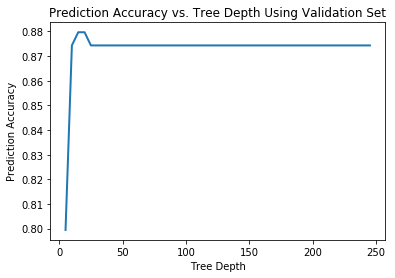

In [114]:
plt.plot([5*i for i in range(1, 50)], acc_val, linewidth=2.0, label="L2 Norm")
plt.title("Prediction Accuracy vs. Tree Depth Using Validation Set")
plt.ylabel("Prediction Accuracy")
plt.xlabel("Tree Depth")
plt.show()

In [118]:
max(acc_val)

0.8796791443850267

In [117]:
t = ID3(train_data_d, "SPAM_LABEL", tree_attr, 15)
z = tree_classify(t, test_data_d)
((z==test_data_d["SPAM_LABEL"]).sum()/test_data_d.shape[0])

Best feature: thi
Best feature: hpl
Best feature: pleas
Best feature: http
Best feature: ga
Best feature: subject
Best feature: deal
Best feature: daren
Best feature: meter
Best feature: enron
Best feature: mmbtu
Best feature: volum
Best feature: pm
Best feature: contract
Best feature: ticket
Best feature: email
Best feature: product
Best feature: price
Best feature: pill
Best feature: need
Best feature: meter
Best feature: daren
Best feature: juli
Best feature: path
Best feature: ticket
Best feature: chang
Best feature: meter
Best feature: sale
Best feature: contract
Best feature: daren
Best feature: product
Best feature: pm
Best feature: ect
Best feature: chang
Best feature: need
Best feature: wa
Best feature: path
Best feature: meter
Best feature: need
Best feature: cc
Best feature: com
Best feature: chang
Best feature: corp
Best feature: pm
Best feature: contract
Best feature: ect
Best feature: deal
Best feature: pm
Best feature: email
Best feature: inform
Best feature: line
Best f

0.8724523339907956

# Testing Learning Curve

In [204]:
def bayes_comp(train_data):
    train_data_b0 = train_data[train_data["SPAM_LABEL"]==0]
    train_data_b1 = train_data[train_data["SPAM_LABEL"]==1]

    #build frequency table
    freq_0 = [c.Counter(train_data_b0[col]) for col in attr]
    freq_1 = [c.Counter(train_data_b1[col]) for col in attr]

    #get counts
    counts = train_data["SPAM_LABEL"].value_counts()
    total = counts.sum()

    #get test data
    test_data_bayes = test_data.copy()
    test_data_bayes["SPAM_LABEL_y"] = -1

    #classiying
    for row in test_data.itertuples():
        p_0 = bayes_prob(row, freq_0, attr, counts[0]) + math.log(counts[0]/total)
        p_1 = bayes_prob(row, freq_1, attr, counts[1]) + math.log(counts[1]/total)

        #give label
        if p_0 > p_1:
            test_data_bayes["SPAM_LABEL_y"].loc[row[0]] = 0
        else:
            test_data_bayes["SPAM_LABEL_y"].loc[row[0]] = 1

    return len(test_data_bayes[test_data_bayes["SPAM_LABEL_y"] == test_data_bayes["SPAM_LABEL"]].index)/len(test_data_bayes.index)

def KNN_comp(k, norms_comp, train_data):
    y = []
    neighbors = np.apply_along_axis(np.argpartition, 1, norms_comp, k)[:,:k]
    for i in range(test_data.shape[0]):
        y.append(train_data.iloc[list(neighbors[i]), :]["SPAM_LABEL"].mode()[0])
    return np.equal(np.array(y), test_data["SPAM_LABEL"].values).sum()/test_data.shape[0]

    
    

In [242]:
x = []
y_tree = []
y_knn = []
y_bay = []

attr = train_data.columns.drop("SPAM_LABEL")
#accuracy
for i in range(1, 11):
    print(i)
    msk = np.random.rand(len(ham_train)) < 0.1*i
    ham_train_comp = ham_train[msk]
    msk = np.random.rand(len(spam_train)) < 0.1*i
    spam_train_comp = spam_train[msk]
    train_data_comp = pd.concat([ham_train_comp, spam_train_comp])
    norms_comp = sp.cdist(test_data[attr], train_data_comp[attr])
    
    t = ID3(train_data_comp, "SPAM_LABEL", tree_attr, 15)
    z = tree_classify(t, test_data)
    y_tree.append(np.equal(np.array(z), test_data["SPAM_LABEL"].values).sum()/test_data.shape[0])
    y_knn.append(KNN_split(1,norms_comp, train_data_comp, test_data))
    
    y_bay.append(bayes_comp(train_data_comp))

1
2
3
4
5
6
7
8
9
10


In [243]:
np.array_equal(norms_comp, norms)

True

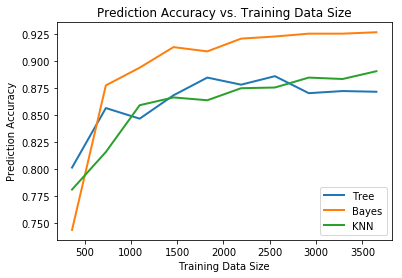

In [244]:
list_k = [0.1*i*train_data.shape[0] for i in range(1, 11)]
plt.plot(list_k, y_tree, linewidth=2.0, label="Tree")
plt.plot(list_k, y_bay, linewidth=2.0, label="Bayes")
plt.plot(list_k, y_knn, linewidth=2.0, label="KNN")
plt.legend()
plt.title("Prediction Accuracy vs. Training Data Size")
plt.ylabel("Prediction Accuracy")
plt.xlabel("Training Data Size")

plt.show()

[0.7113740959894806,
 0.7856673241288626,
 0.8553583168967784,
 0.8251150558842867,
 0.8961209730440499,
 0.89086127547666,
 0.9697567389875082,
 0.9112426035502958,
 0.9375410913872453,
 0.967784352399737]

# Testing different splits

In [251]:
def KNN_split(k, norms_comp, train_data, test_data):
    y = []
    neighbors = np.apply_along_axis(np.argpartition, 1, norms_comp, k)[:,:k]
    for i in range(test_data.shape[0]):
        y.append(train_data.iloc[list(neighbors[i]), :]["SPAM_LABEL"].mode()[0])
    return np.equal(np.array(y), test_data["SPAM_LABEL"].values).sum()/test_data.shape[0]

splits = [.5, .6, .7, .8, .9]

x = []
y_tree = []
y_knn = []
y_bay = []

    
for s in splits:
    msk = np.random.rand(len(ham_data)) < s
    ham_train_split = ham_data[msk]
    ham_test_split = ham_data[~msk]

    msk = np.random.rand(len(spam_data)) < s
    spam_train_split = spam_data[msk]
    spam_test_split = spam_data[~msk]

    train_data_split = pd.concat([ham_train_split, spam_train_split])
    test_data_split = pd.concat([ham_test_split, spam_test_split])
    
    norms_comp = sp.cdist(test_data_split[attr], train_data_split[attr])
    
    t = ID3(train_data_split, "SPAM_LABEL", tree_attr, 15)
    z = tree_classify(t, test_data_split)
    y_tree.append(np.equal(np.array(z), test_data_split["SPAM_LABEL"].values).sum()/test_data_split.shape[0])
    y_knn.append(KNN_split(1,norms_comp, train_data_split, test_data_split))
    y_bay.append(bayes_comp(train_data_split))

In [200]:
y_tree = [0.8878612716763006,
 0.8815984213122842,
 0.886084142394822,
 0.8661087866108786,
 0.8809523809523809]

[0.8878612716763006,
 0.8815984213122842,
 0.886084142394822,
 0.8661087866108786,
 0.8809523809523809]

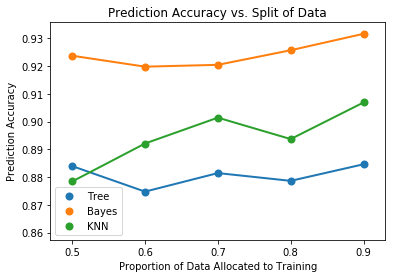

In [254]:
# splits = splits[:4]
plt.scatter(splits, y_tree, linewidth=2.0, label="Tree")
plt.scatter(splits, y_bay, linewidth=2.0, label="Bayes")
plt.scatter(splits, y_knn, linewidth=2.0, label="KNN")
plt.plot(splits, y_tree, linewidth=2.0)
plt.plot(splits, y_bay, linewidth=2.0)
plt.plot(splits, y_knn, linewidth=2.0)
plt.legend()
plt.title("Prediction Accuracy vs. Split of Data")
plt.ylabel("Prediction Accuracy")
plt.xlabel("Proportion of Data Allocated to Training")

plt.show()

In [245]:
test_data.shape

(1521, 1546)